#Data Reliability Check and Analysis with ERA5 Rainfall Data


###Mount Google Drive and Install Packages

In [ ]:
# Mount Google Drive to access your data
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install rasterio
!pip install netCDF4
!pip install adjustText

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import os
import gzip
from bs4 import BeautifulSoup
import rasterio # extract data from chirps data (.tif)
from netCDF4 import Dataset # extract data from era5 (.nc)
import json

###Define Data Paths and Load Data

In [ ]:
# Define the path to your data folder
data_path = r'/content/drive/Shareddrives/Ishango - Barry Callebaut/'

# List of all spreadsheets
All_spreadsheets = ["2017_FFB_CDI_BC.xlsx", "2018_FFB_CDI_BC.xlsx", "2019_FFB_CDI_BC.xlsx", "2020_FFB_CDI_BC.xlsx",
                    "2021_FFB_CDI_BC.xlsx", "2022_FFB_CDI_BC.xlsx","polygon_data.xlsx"]

# Load all Excel files into separate DataFrames
All_DFs = [pd.read_excel(data_path + spreadsheet) for spreadsheet in All_spreadsheets]

###Get Rainfall data from CHIRPS


In [ ]:
# URL of the site containing the .gz files
base_url = 'https://data.chc.ucsb.edu/products/CHIRPS-2.0/africa_monthly/tifs/'
ext = '.tif.gz'

def get_url_paths(url, ext=''):
    response = requests.get(url)
    response_text = response.text
    soup = BeautifulSoup(response_text, 'html.parser')
    file = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    return file[-2:]  #extracts data from 2021

def extract_gz(gz_file, extract_dir):
    with gzip.open(gz_file, 'rb') as f_in:
        with open(extract_dir, 'wb') as f_out:
            f_out.write(f_in.read())

result = get_url_paths(base_url, ext)

# Directory to store downloaded and extracted files
download_dir = 'downloaded_gz'
extracted_dir = 'extracted_files'
os.makedirs(download_dir, exist_ok=True)
os.makedirs(extracted_dir, exist_ok=True)

for file in result:
    f_name = file[-14:-7]
    gz_file_path = os.path.join(download_dir, f_name + '.tif.gz')
    extract_file_path = os.path.join(extracted_dir, f_name + '.tif')

    # Download the .gz file
    r = requests.get(file)
    with open(gz_file_path, 'wb') as f:
        f.write(r.content)

    # Extract the .gz file
    extract_gz(gz_file_path, extract_file_path)

###Get Farm coodinates from the polygon dataset to calculate rainfall values in mm using CHIRPS Dataset


In [ ]:
# Get polygon dataset
polygon_data = All_DFs[6]

# Directory containing extracted files
extracted_dir = 'extracted_files'

# Function to get rainfall value for a given coordinate from a GeoTiff file
def get_rainfall(file_path, x, y):
    with rasterio.open(file_path) as dataset:
        row, col = dataset.index(x, y)
        data = dataset.read(1)
        rainfall_mm = data[int(row), int(col)]
        return rainfall_mm

# Create a dictionary to store rainfall values for each file
data_rows = []

# Iterate over rows in the Excel DataFrame
for index, row in polygon_data.iterrows():
    farmer_barcode = row['FARMER_BARCODE']
    plantation_code = row['PLANTATION_CODE']
    coordinate_json = row['SHAPE']

    # Parse the JSON coordinates to extract the desired coordinate
    coordinate_data = json.loads(coordinate_json)
    x, y = coordinate_data['geometry']['coordinates'][0][0][:2]  # Assuming the first coordinate is the desired one

    # Iterate over files in the extracted directory
    for file_name in os.listdir(extracted_dir):
        if file_name.endswith('.tif'):
            file_path = os.path.join(extracted_dir, file_name)

            # Get rainfall value for the given coordinate
            rainfall_value = get_rainfall(file_path, x, y)

            # Remove the file extension from the file name
            year_month = os.path.splitext(file_name)[0]

            # Append data to the list
            data_rows.append([farmer_barcode, plantation_code, year_month, rainfall_value])

# Create DataFrame from the data list
columns = ['Farmer Code', 'Plantation Code', 'Year Month', 'Rainfall (mm)']
df_final = pd.DataFrame(data_rows, columns=columns)

# Pivot the DataFrame to have distinct file names as columns
df_pivoted = df_final.pivot_table(index=['Farmer Code', 'Plantation Code'],
                                  columns='Year Month',
                                  values='Rainfall (mm)',
                                  aggfunc='first').reset_index()

df_pivoted.head()

Year Month,Farmer Code,Plantation Code,2024.02,2024.03
0,900015000A0001,0-37159-1,32.124023,172.425812
1,900015000A0001,0-37159-2,32.124023,172.425812
2,900015000A0003,0-37161-1,32.124023,172.425812
3,900015000A0004,0-37162-1,32.124023,172.425812
4,900015000A0004,0-37162-2,32.124023,172.425812


###Get Rainfall data from ERA5

In [ ]:
file_path = '/content/total_precipitation_IC.nc'

# Open the NetCDF file
data = Dataset(file_path, 'r')

# get the values for all the variables
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
time_values = data.variables['time'][:]
rainfall_values = data.variables['tp'][:]

# Get units for time
time_unit = data.variables['time'].units

###Get Farm coodinates from the polygon dataset to calculate rainfall values in mm using ERA5 Dataset

In [ ]:
# Get polygon dataset
polygon_data = All_DFs[6]

# Function to get rainfall value for a given coordinate and time
def get_rainfall(index_time, min_index_lat, min_index_lon):
  rainfall_value = rainfall_values[index_time, min_index_lat, min_index_lon]
  return rainfall_value

# Convert time unit to datetime format
ref_date = datetime.strptime(time_unit[12:-2], '%Y-%m-%d %H:%M:%S')

# Create a dictionary to store rainfall values for each year
data_rows = []

date_range = []
rainfall_val = []
# Iterate over rows in the Excel DataFrame
for index, row in polygon_data.iterrows():
    farmer_barcode = row['FARMER_BARCODE']
    plantation_code = row['PLANTATION_CODE']
    coordinate_json = row['SHAPE']

    # Parse the JSON coordinates to extract the desired coordinate
    coordinate_data = json.loads(coordinate_json)
    # Get longitude and latitude of a farm
    my_lon, my_lat = coordinate_data['geometry']['coordinates'][0][0][:2]  # Assuming the first coordinate is the desired one

   #squared difference of lon and lat
    sq_diff_lon = (lon - my_lon) ** 2
    sq_diff_lat = (lat - my_lat) ** 2

    #identifying the index of the minimum value for lon and lat
    min_index_lat = sq_diff_lat.argmin()
    min_index_lon = sq_diff_lon.argmin()

    for index_time, time_val in enumerate(time_values):
      # Calculate date-time values using timedelta from datetime instance
      date_time = ref_date + timedelta(hours=int(time_val))
      yearmonth= date_time.strftime('%Y.%m')

      # Extract rainfall value at specific coordinates and time
      rainfall_val = get_rainfall(index_time, min_index_lat, min_index_lon)

      # Convert rainfall value to mm/month
      rainfall_val_converted = rainfall_val *30000

      # Append data to the list
      data_rows.append([farmer_barcode, yearmonth, rainfall_val_converted])


# Create DataFrame from the data list
columns = ['IMS code', 'Year Month', 'Rainfall (mm)']
df_final = pd.DataFrame(data_rows, columns=columns)

# Pivot the DataFrame to have distinct file names as columns
df_pivoted = df_final.pivot_table(index=['IMS code'],
                                  columns='Year Month',
                                  values='Rainfall (mm)',
                                  aggfunc='first').reset_index()

df_pivoted.head()

Year Month,IMS code,2021.01,2021.02,2021.03,2021.04,2021.05,2021.06,2021.07,2021.08,2021.09,...,2023.03,2023.04,2023.05,2023.06,2023.07,2023.08,2023.09,2023.10,2023.11,2023.12
0,900015000A0001,5.201416,42.236122,84.862741,67.118572,46.297288,128.114155,81.42637,152.949745,307.898832,...,102.544432,80.192401,87.611838,72.554286,63.401043,85.893653,122.397283,164.680265,69.63337,1.437028
1,900015000A0003,5.201416,42.236122,84.862741,67.118572,46.297288,128.114155,81.42637,152.949745,307.898832,...,102.544432,80.192401,87.611838,72.554286,63.401043,85.893653,122.397283,164.680265,69.63337,1.437028
2,900015000A0004,5.201416,42.236122,84.862741,67.118572,46.297288,128.114155,81.42637,152.949745,307.898832,...,102.544432,80.192401,87.611838,72.554286,63.401043,85.893653,122.397283,164.680265,69.63337,1.437028
3,900015000A0008,5.201416,42.236122,84.862741,67.118572,46.297288,128.114155,81.42637,152.949745,307.898832,...,102.544432,80.192401,87.611838,72.554286,63.401043,85.893653,122.397283,164.680265,69.63337,1.437028
4,900015000A0009,5.201416,42.236122,84.862741,67.118572,46.297288,128.114155,81.42637,152.949745,307.898832,...,102.544432,80.192401,87.611838,72.554286,63.401043,85.893653,122.397283,164.680265,69.63337,1.437028


###Adding total rainfall for 2021 and 2022

In [ ]:
#calculate the total rainfall for 2021 and 2022 based on monthly values
df_pivoted["RF_2021"] = df_pivoted[["2021.03", "2021.04", "2021.05", "2021.06", "2021.07", "2021.08","2021.09", "2021.10", "2021.11", "2021.12","2022.01","2022.02"]].sum(axis=1)
df_pivoted["RF_2022"] = df_pivoted[["2022.03", "2022.04", "2022.05", "2022.06", "2022.07", "2022.08","2022.09", "2022.10", "2022.11", "2022.12","2023.01","2023.02"]].sum(axis=1)

#drop duplicate codes
final_era5_df = df_pivoted.drop_duplicates(subset='IMS code', keep='first')[["IMS code", "RF_2021", "RF_2022"]]

final_era5_df.head()

Year Month,IMS code,RF_2021,RF_2022
0,900015000A0001,1008.38742,911.231843
1,900015000A0003,1008.38742,911.231843
2,900015000A0004,1008.38742,911.231843
3,900015000A0008,1008.38742,911.231843
4,900015000A0009,1008.38742,911.231843


###Merging CHIRPS and ERA5 rainfall data on IMS

In [ ]:
# 2021 and 2022 dataframe
FFB_CDI_BC_2021_DF = All_DFs[4]
FFB_CDI_BC_2022_DF = All_DFs[5]

#Update the columns of 2022 Data
FFB_CDI_BC_2022_DF.columns=FFB_CDI_BC_2022_DF.iloc[0].tolist()
FFB_CDI_BC_2022_DF = FFB_CDI_BC_2022_DF.drop(0).reset_index(drop=True)

#relevant columns

rel_columns_2021 = ["IMS code", "Year",  "Country", "Province", "District (enter letter code)","SprayingTotal cost (FCFA)Per Ha", "TotalVolume dry beans (kg)Per Ha", "RF_total"]
rel_columns_2022 = ["IMS code", "Year", "Country", "Province", "District (enter letter code)","SprayingTotal cost (FCFA)Per Ha", "TotalVolume dry beans (kg)Per Ha", "RF_total"]

# 2021 and 2022 dataframe on relevant columns
New_FFB_CDI_BC_2021_DF = FFB_CDI_BC_2021_DF[rel_columns_2021]
New_FFB_CDI_BC_2022_DF = FFB_CDI_BC_2022_DF[rel_columns_2022]


merged_2021 = pd.merge(New_FFB_CDI_BC_2021_DF, final_era5_df, on="IMS code")
merged_2021 = merged_2021.drop(columns=['RF_2022'])
merged_2021 = merged_2021.rename(columns={'RF_2021': 'RF_2021_ERA5', 'RF_total': 'RF_2021_CHIRPS'})

merged_2022 = pd.merge(final_era5_df, New_FFB_CDI_BC_2022_DF, on="IMS code")
merged_2022 = merged_2022.drop(columns=['RF_2021'])
merged_2022 = merged_2022.rename(columns={'RF_2022': 'RF_2022_ERA5', 'RF_total': 'RF_2022_CHIRPS'})

###Between Analysis

###Scatter Plot of CHIRPS Rainfall vs ERA5 Rainfall per Province

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from adjustText import adjust_text

province_2022 = merged_2022.groupby("Province").agg({'RF_2022_ERA5': 'mean', 'RF_2022_CHIRPS': 'mean'}).reset_index()
province_2021 = merged_2021.groupby("Province").agg({'RF_2021_ERA5': 'mean', 'RF_2021_CHIRPS': 'mean'}).reset_index()

# Calculate Pearson correlation and p-value for 2021 data
pearson_corr_2021, pvalue_2021 = pearsonr(province_2021["RF_2021_CHIRPS"], province_2021["RF_2021_ERA5"])

# Calculate Pearson correlation and p-value for 2022 data
pearson_corr_2022, pvalue_2022 = pearsonr(province_2022["RF_2022_CHIRPS"], province_2022["RF_2022_ERA5"])



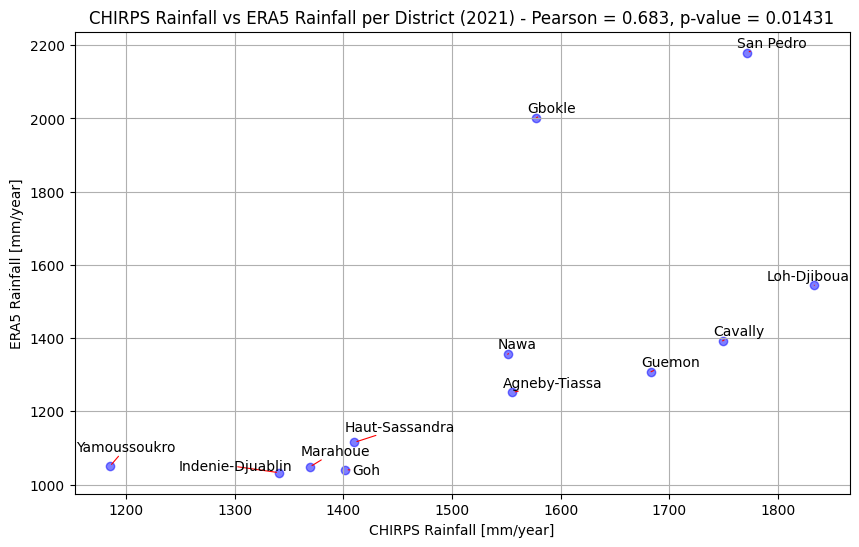

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(province_2021["RF_2021_CHIRPS"], province_2021["RF_2021_ERA5"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2021["RF_2021_CHIRPS"], province_2021["RF_2021_ERA5"], province_2021["Province"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8))

plt.title('CHIRPS Rainfall vs ERA5 Rainfall per District (2021) - Pearson = {:.3f}, p-value = {:.5f}'.format(pearson_corr_2021, pvalue_2021))

plt.xlabel('CHIRPS Rainfall [mm/year]')
plt.ylabel('ERA5 Rainfall [mm/year]')

plt.grid(True)
plt.show()

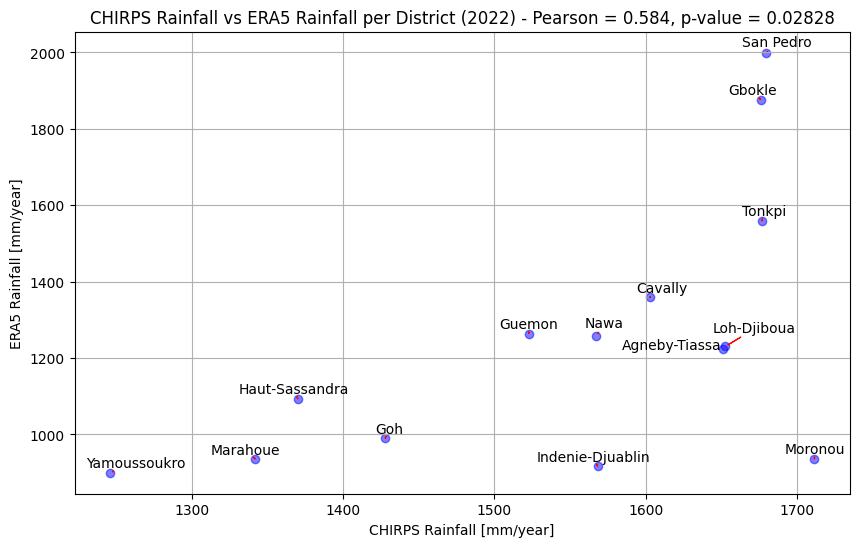

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(province_2022["RF_2022_CHIRPS"], province_2022["RF_2022_ERA5"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2022["RF_2022_CHIRPS"], province_2022["RF_2022_ERA5"], province_2022["Province"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(color='red', lw=0.8))

plt.title('CHIRPS Rainfall vs ERA5 Rainfall per District (2022) - Pearson = {:.3f}, p-value = {:.5f}'.format(pearson_corr_2022, pvalue_2022))

plt.xlabel('CHIRPS Rainfall [mm/year]')
plt.ylabel('ERA5 Rainfall [mm/year]')

plt.grid(True)
plt.show()

###Within Analysis

In [ ]:
#create a new dataframe to merge 2021 and 2022 dataframe
province_2021_2022 = pd.merge(province_2022, province_2021, on="Province")

#Create columns for the difference in CHIRPS and ERA5 for 2021 and 2022
province_2021_2022["RF_CHIRPS_difference"] = province_2021_2022["RF_2022_CHIRPS"] - province_2021_2022["RF_2021_CHIRPS"]
province_2021_2022["RF_ERA5_difference"] = province_2021_2022["RF_2022_ERA5"] - province_2021_2022["RF_2021_ERA5"]

province_2021_2022

,Province,RF_2022_ERA5,RF_2022_CHIRPS,RF_2021_ERA5,RF_2021_CHIRPS,RF_CHIRPS_difference,RF_ERA5_difference
0,Agneby-Tiassa,1223.688412,1650.886747,1251.643699,1555.611567,95.27518,-27.955286
1,Cavally,1358.795590,1602.659626,1392.527773,1749.037632,-146.378005,-33.732183
2,Gbokle,1876.317240,1675.968305,2001.463732,1577.628980,98.339325,-125.146491
3,Goh,989.544554,1427.866615,1040.497529,1401.918611,25.948005,-50.952974
4,Guemon,1263.921158,1522.832863,1308.245367,1683.223374,-160.390511,-44.324210
5,Haut-Sassandra,1092.856908,1370.172279,1115.186372,1410.045695,-39.873416,-22.329464
6,Indenie-Djuablin,916.629399,1568.256257,1032.481985,1341.082761,227.173496,-115.852585
7,Loh-Djiboua,1230.269446,1652.721011,1544.299326,1833.438459,-180.717448,-314.029880
8,Marahoue,935.936826,1342.013035,1047.963446,1369.005040,-26.992005,-112.026620
9,Nawa,1257.825278,1567.469398,1355.899470,1551.323853,16.145545,-98.074192


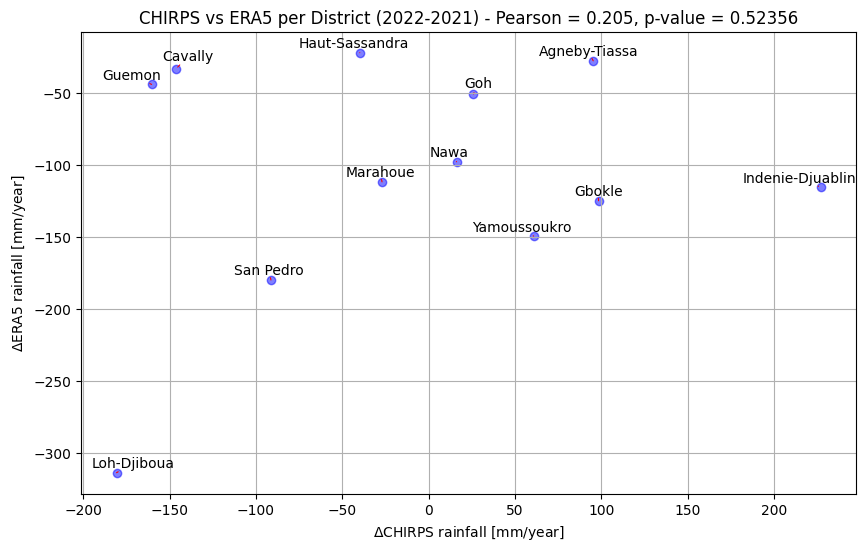

In [ ]:
pearson_corr, pvalue = pearsonr(province_2021_2022["RF_CHIRPS_difference"], province_2021_2022["RF_ERA5_difference"])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(province_2021_2022["RF_CHIRPS_difference"], province_2021_2022["RF_ERA5_difference"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2021_2022["RF_CHIRPS_difference"], province_2021_2022["RF_ERA5_difference"], province_2021_2022["Province"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8))

plt.title(f'CHIRPS vs ERA5 per District (2022-2021) - Pearson = {pearson_corr:.3f}, p-value = {pvalue:.5f}')

plt.xlabel('$\Delta$CHIRPS rainfall [mm/year]')
plt.ylabel('$\Delta$ERA5 rainfall [mm/year]')

plt.grid(True)
plt.show()

###Finding the correlation between Yield and ERA5 Rainfall data

In [ ]:
#Select relevant columns to use and drop duplicates
df_pivoted_2021 = df_pivoted[["IMS code", "2021.03", "2021.04", "2021.05", "2021.06", "2021.07", "2021.08","2021.09", "2021.10", "2021.11", "2021.12","2022.01","2022.02","RF_2021"]]
final_era5_df_2021 = df_pivoted_2021.drop_duplicates(subset='IMS code', keep='first')

df_pivoted_2022 = df_pivoted[["IMS code", "2022.03", "2022.04", "2022.05", "2022.06", "2022.07", "2022.08","2022.09", "2022.10", "2022.11", "2022.12","2023.01","2023.02","RF_2022"]]
final_era5_df_2022 = df_pivoted_2022.drop_duplicates(subset='IMS code', keep='first')

In [ ]:
#merge the ERA5 dataset with the actual dataset for 2021 and 2022 on IMS
merged_with_era5_2021 = pd.merge(New_FFB_CDI_BC_2021_DF, final_era5_df_2021, on=["IMS code"], suffixes=('_CHIRPS', '_ERA5'))

merged_with_era5_2022 = pd.merge(New_FFB_CDI_BC_2022_DF, final_era5_df_2022, on=["IMS code"], suffixes=('_CHIRPS', '_ERA5'))


# Adding the seasonal totals
merged_with_era5_2021.loc[:, "MAM_rainfall_2021"] = merged_with_era5_2021.copy()[["2021.03", "2021.04", "2021.05"]].sum(axis=1)
merged_with_era5_2021.loc[:, "JJA_rainfall_2021"] = merged_with_era5_2021.copy()[["2021.06", "2021.07", "2021.08"]].sum(axis=1)
merged_with_era5_2021.loc[:, "SON_rainfall_2021"] = merged_with_era5_2021.copy()[["2021.09", "2021.10", "2021.11"]].sum(axis=1)
merged_with_era5_2021.loc[:, "DJF_rainfall_2021"] = merged_with_era5_2021.copy()[["2021.12","2022.01","2022.02"]].sum(axis=1)

merged_with_era5_2022.loc[:, "MAM_rainfall_2022"] = merged_with_era5_2022.copy()[["2022.03", "2022.04", "2022.05"]].sum(axis=1)
merged_with_era5_2022.loc[:, "JJA_rainfall_2022"] = merged_with_era5_2022.copy()[["2022.06", "2022.07", "2022.08"]].sum(axis=1)
merged_with_era5_2022.loc[:, "SON_rainfall_2022"] = merged_with_era5_2022.copy()[["2022.09", "2022.10", "2022.11"]].sum(axis=1)
merged_with_era5_2022.loc[:, "DJF_rainfall_2022"] = merged_with_era5_2022.copy()[["2022.12","2023.01","2023.02"]].sum(axis=1)

merged_with_era5_2021.head()

,IMS code,Year,Country,Province,District (enter letter code),SprayingTotal cost (FCFA)Per Ha,TotalVolume dry beans (kg)Per Ha,RF_total,2021.03,2021.04,...,2021.10,2021.11,2021.12,2022.01,2022.02,RF_2021,MAM_rainfall_2021,JJA_rainfall_2021,SON_rainfall_2021,DJF_rainfall_2021
0,900211000C0245,2021,COTE D'IVOIRE,Yamoussoukro,CN1,4502.164502,71.861472,1184.58657,68.524360,71.523374,...,97.733512,33.535856,2.171162,0.827853,12.355315,1037.346654,182.908651,363.005726,476.077948,15.354330
1,900211000C0238,2021,COTE D'IVOIRE,Yamoussoukro,CN1,14203.655350,624.804178,1126.40656,68.524360,71.523374,...,97.733512,33.535856,2.171162,0.827853,12.355315,1037.346654,182.908651,363.005726,476.077948,15.354330
2,900211000C0218,2021,COTE D'IVOIRE,Yamoussoukro,CN1,9119.047619,332.142857,1168.89845,68.524360,71.523374,...,97.733512,33.535856,2.171162,0.827853,12.355315,1037.346654,182.908651,363.005726,476.077948,15.354330
3,900211000C0242,2021,COTE D'IVOIRE,Yamoussoukro,CN1,0.000000,123.142857,1168.89845,68.524360,71.523374,...,97.733512,33.535856,2.171162,0.827853,12.355315,1037.346654,182.908651,363.005726,476.077948,15.354330
4,900211000C0216,2021,COTE D'IVOIRE,Yamoussoukro,CN1,1875.000000,149.038462,1184.58657,84.862741,67.118572,...,92.469617,33.020400,3.311412,0.968432,9.949856,1008.387420,198.278601,362.490270,433.388850,14.229699


###Between Analysis(2021)


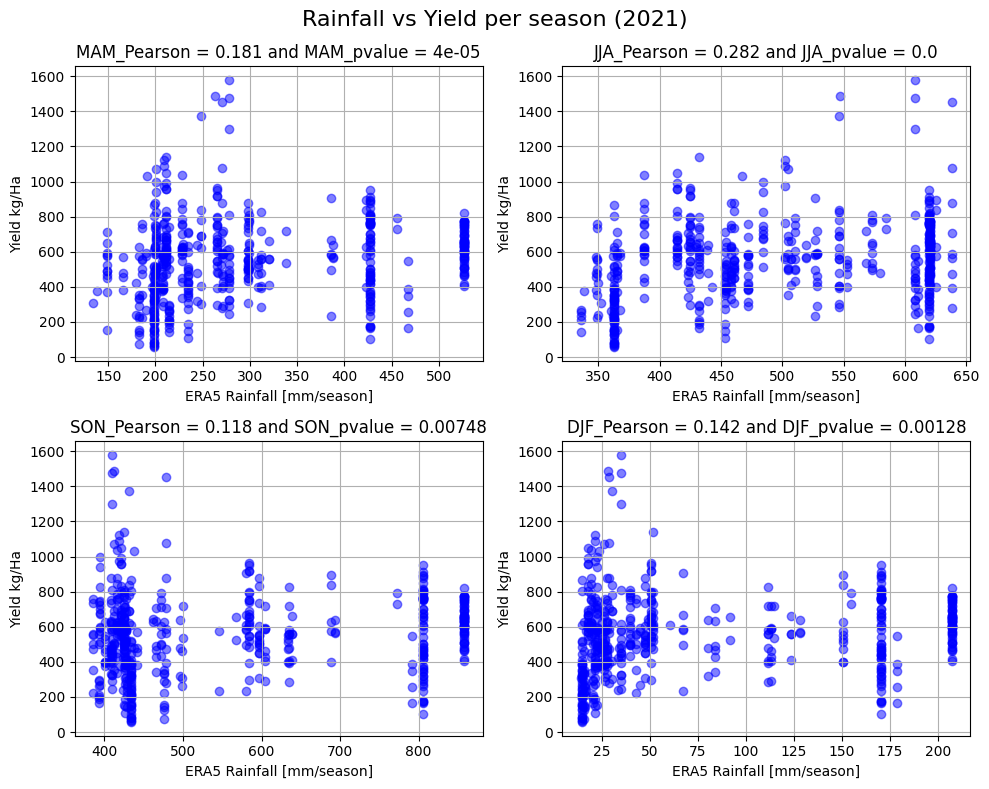

In [ ]:
L = ["MAM","JJA","SON","DJF"]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    if i < 4:
      ax.scatter(merged_with_era5_2021[L[i]+"_rainfall_2021"], merged_with_era5_2021['TotalVolume dry beans (kg)Per Ha'], color='blue', alpha=0.5)
      pearson_corr, pvalue = pearsonr(merged_with_era5_2021[L[i]+"_rainfall_2021"], merged_with_era5_2021['TotalVolume dry beans (kg)Per Ha'])
      ax.set_title(L[i]+"_Pearson = "+str(round(pearson_corr,3))+ " and "+L[i]+"_pvalue = "+str(round(pvalue,5)))
      ax.set_xlabel('ERA5 Rainfall [mm/season]')
      ax.set_ylabel('Yield kg/Ha')
      ax.grid(True)
    i+=1

# Add a main title
fig.suptitle('Rainfall vs Yield per season (2021)', fontsize=16)

plt.tight_layout()

# Show plots
plt.show()

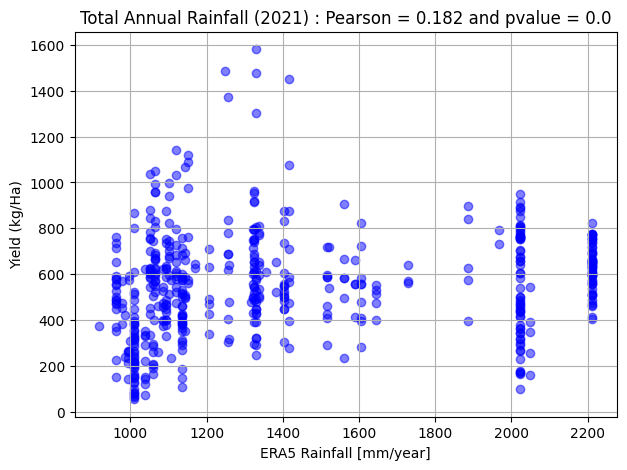

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(merged_with_era5_2021["RF_2021"], merged_with_era5_2021["TotalVolume dry beans (kg)Per Ha"], color='blue', alpha=0.5)

pearson_corr, pvalue = pearsonr(merged_with_era5_2021["RF_2021"], merged_with_era5_2021['TotalVolume dry beans (kg)Per Ha'])

plt.title("Total Annual Rainfall (2021) : Pearson = " + str(round(pearson_corr,3))+ " and pvalue = " +str(round(pvalue,4)))
plt.xlabel("ERA5 Rainfall [mm/year]")
plt.ylabel("Yield (kg/Ha)")


plt.grid(True)
plt.show()

###Between Analysis(2022)

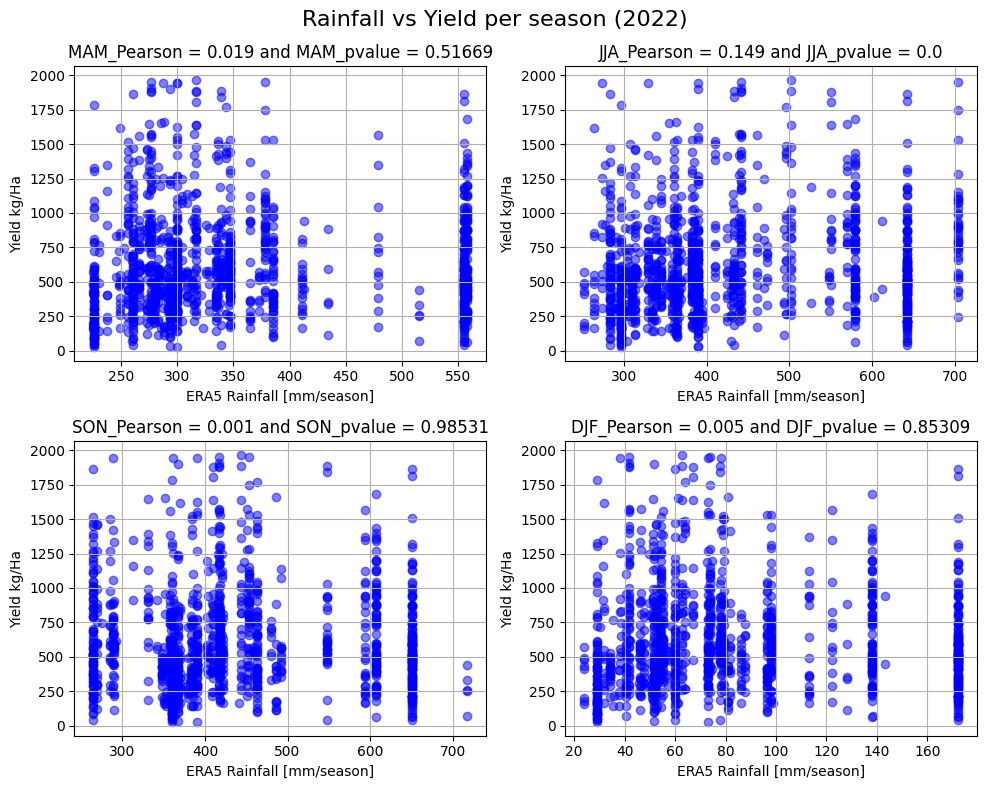

In [ ]:
L = ["MAM","JJA","SON","DJF"]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    if i < 4:
      ax.scatter(merged_with_era5_2022[L[i]+"_rainfall_2022"], merged_with_era5_2022['TotalVolume dry beans (kg)Per Ha'], color='blue', alpha=0.5)
      pearson_corr, pvalue = pearsonr(merged_with_era5_2022[L[i]+"_rainfall_2022"], merged_with_era5_2022['TotalVolume dry beans (kg)Per Ha'])
      ax.set_title(L[i]+"_Pearson = "+str(round(pearson_corr,3))+ " and "+L[i]+"_pvalue = "+str(round(pvalue,5)))
      ax.set_xlabel('ERA5 Rainfall [mm/season]')
      ax.set_ylabel('Yield kg/Ha')
      ax.grid(True)
    i+=1

# Add a main title
fig.suptitle('Rainfall vs Yield per season (2022)', fontsize=16)

plt.tight_layout()

# Show plots
plt.show()

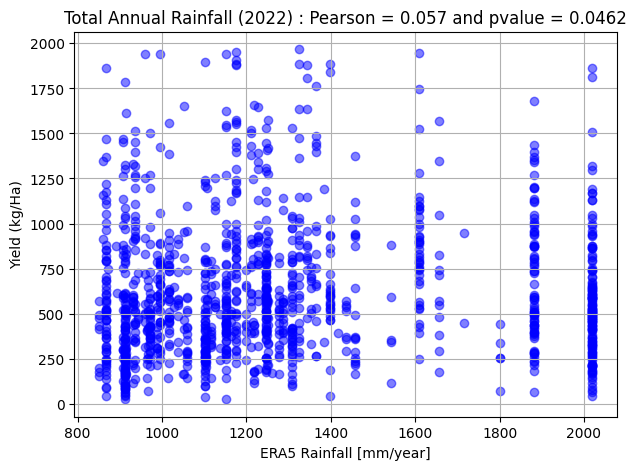

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(merged_with_era5_2022["RF_2022"], merged_with_era5_2022["TotalVolume dry beans (kg)Per Ha"], color='blue', alpha=0.5)

pearson_corr, pvalue = pearsonr(merged_with_era5_2022["RF_2022"], merged_with_era5_2022['TotalVolume dry beans (kg)Per Ha'])

plt.title("Total Annual Rainfall (2022) : Pearson = " + str(round(pearson_corr,3))+ " and pvalue = " +str(round(pvalue,4)))
plt.xlabel("ERA5 Rainfall [mm/year]")
plt.ylabel("Yield (kg/Ha)")


plt.grid(True)
plt.show()

###Within Analysis(2021-2022)

In [ ]:
# Merge the two datasets on IMS codes
merged_with_era5_2021_2022 = pd.merge(merged_with_era5_2022, merged_with_era5_2021, on="IMS code", suffixes=('_2022', '_2021'))

merged_with_era5_2021_2022["yield_difference"] = merged_with_era5_2021_2022["TotalVolume dry beans (kg)Per Ha_2022"] - merged_with_era5_2021_2022["TotalVolume dry beans (kg)Per Ha_2021"]
merged_with_era5_2021_2022["rainfall_difference"] = merged_with_era5_2021_2022["RF_2022"] - merged_with_era5_2021_2022["RF_2021"]
merged_with_era5_2021_2022["rainfall_difference_MAM"] = merged_with_era5_2021_2022["MAM_rainfall_2022"] - merged_with_era5_2021_2022["MAM_rainfall_2021"]
merged_with_era5_2021_2022["rainfall_difference_JJA"] = merged_with_era5_2021_2022["JJA_rainfall_2022"] - merged_with_era5_2021_2022["JJA_rainfall_2021"]
merged_with_era5_2021_2022["rainfall_difference_SON"] = merged_with_era5_2021_2022["SON_rainfall_2022"] - merged_with_era5_2021_2022["SON_rainfall_2021"]
merged_with_era5_2021_2022["rainfall_difference_DJF"] = merged_with_era5_2021_2022["DJF_rainfall_2022"] - merged_with_era5_2021_2022["DJF_rainfall_2021"]


merged_with_era5_2021_2022_rel = merged_with_era5_2021_2022[["IMS code", "yield_difference", "rainfall_difference","rainfall_difference_MAM","rainfall_difference_JJA","rainfall_difference_SON","rainfall_difference_DJF"]]
merged_with_era5_2021_2022_rel

,IMS code,yield_difference,rainfall_difference,rainfall_difference_MAM,rainfall_difference_JJA,rainfall_difference_SON,rainfall_difference_DJF
0,900211000A0015,-41.437318,-186.594940,42.595379,-111.931972,-125.771175,8.512828
1,900211000A0027,282.207045,-186.594940,42.595379,-111.931972,-125.771175,8.512828
2,900211000A0931,54.472083,-186.594940,42.595379,-111.931972,-125.771175,8.512828
3,900211000C0216,311.06605,-97.155577,28.022043,-66.728075,-73.413378,14.963833
4,900211000C0218,-177.633951,-186.594940,42.595379,-111.931972,-125.771175,8.512828
...,...,...,...,...,...,...,...
331,900089000C0188,948.260285,69.102295,68.399401,-44.750921,12.855151,32.598664
332,900089000C0190,1172.411261,69.102295,68.399401,-44.750921,12.855151,32.598664
333,900089000C0201,1279.458246,69.102295,68.399401,-44.750921,12.855151,32.598664
334,900089000C0202,1265.774379,69.102295,68.399401,-44.750921,12.855151,32.598664


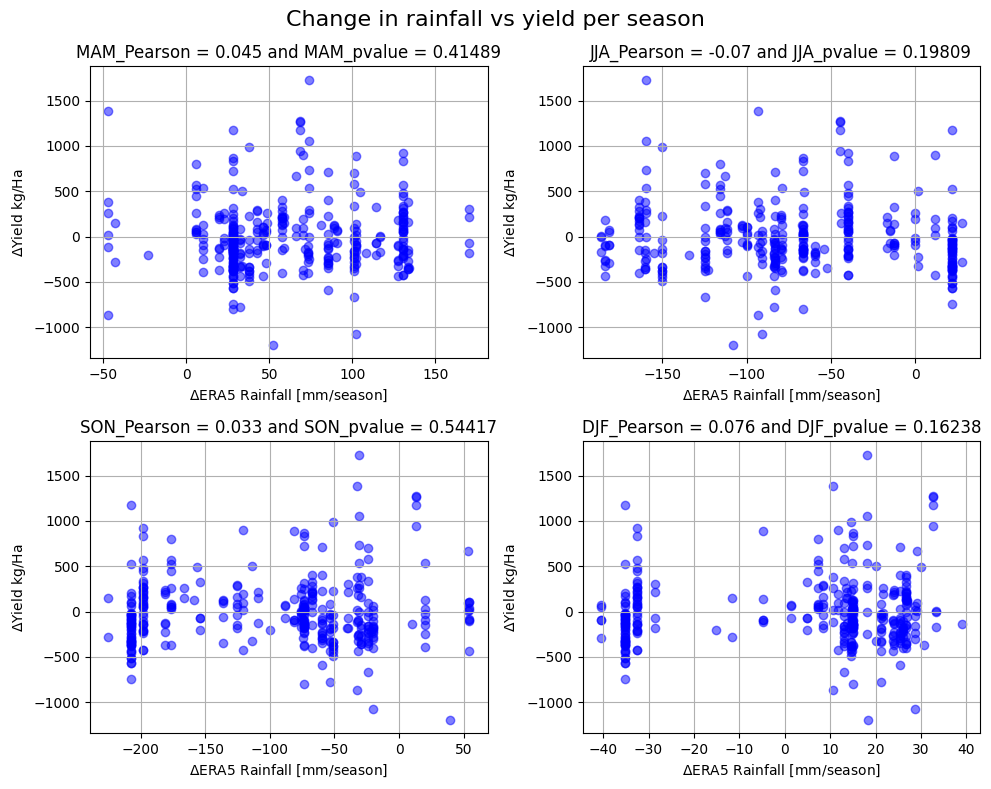

In [ ]:
L = ["MAM","JJA","SON","DJF"]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    if i < 4:
      ax.scatter(merged_with_era5_2021_2022_rel["rainfall_difference_"+ L[i]], merged_with_era5_2021_2022_rel['yield_difference'], color='blue', alpha=0.5)
      pearson_corr, pvalue = pearsonr(merged_with_era5_2021_2022_rel["rainfall_difference_"+ L[i]], merged_with_era5_2021_2022_rel['yield_difference'])
      ax.set_title(L[i]+"_Pearson = "+str(round(pearson_corr,3))+ " and "+L[i]+"_pvalue = "+str(round(pvalue,5)))
      ax.set_xlabel('$\Delta$ERA5 Rainfall [mm/season]')
      ax.set_ylabel('$\Delta$Yield kg/Ha')
      ax.grid(True)
    i+=1

# Add a main title
fig.suptitle('Change in rainfall vs yield per season', fontsize=16)

plt.tight_layout()

# Show plots
plt.show()

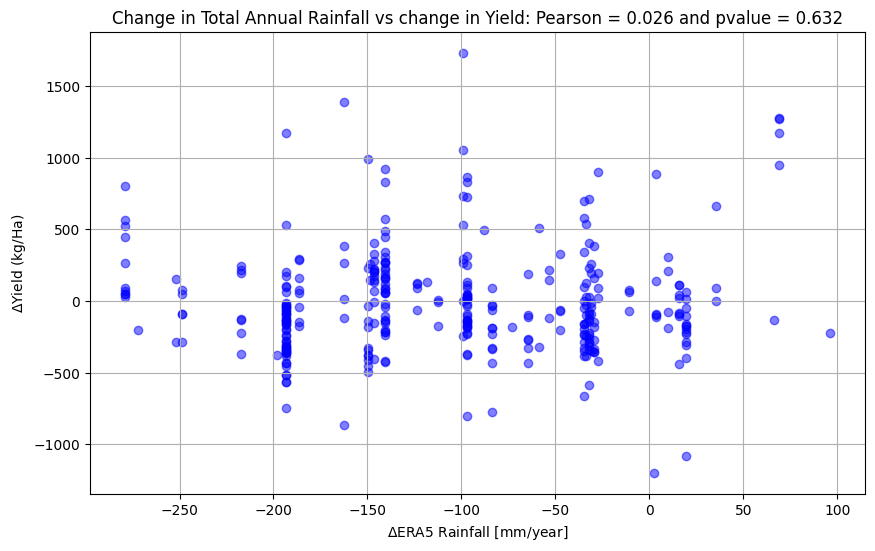

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_with_era5_2021_2022_rel["rainfall_difference"], merged_with_era5_2021_2022_rel["yield_difference"], color='blue', alpha=0.5)

pearson_corr, pvalue = pearsonr(merged_with_era5_2021_2022_rel["rainfall_difference"], merged_with_era5_2021_2022_rel['yield_difference'])

plt.title("Change in Total Annual Rainfall vs change in Yield: Pearson = " + str(round(pearson_corr,3))+ " and pvalue = " +str(round(pvalue,4)))
plt.xlabel("$\Delta$ERA5 Rainfall [mm/year]")
plt.ylabel("$\Delta$Yield (kg/Ha)")


plt.grid(True)
plt.show()

###Between Analysis Per District 2021


In [ ]:
province_2022_with_ERA5 = merged_with_era5_2022.groupby("Province").agg({'RF_2022': 'mean', 'SprayingTotal cost (FCFA)Per Ha':'mean', 'TotalVolume dry beans (kg)Per Ha': 'mean', 'MAM_rainfall_2022': 'mean', 'JJA_rainfall_2022':'mean', 'SON_rainfall_2022':'mean', 'DJF_rainfall_2022':'mean'}).reset_index()
province_2021_with_ERA5 = merged_with_era5_2021.groupby("Province").agg({'RF_2021': 'mean', 'SprayingTotal cost (FCFA)Per Ha':'mean', 'TotalVolume dry beans (kg)Per Ha': 'mean', 'MAM_rainfall_2021': 'mean', 'JJA_rainfall_2021':'mean', 'SON_rainfall_2021':'mean', 'DJF_rainfall_2021':'mean'}).reset_index()
province_2022_with_ERA5

,Province,RF_2022,SprayingTotal cost (FCFA)Per Ha,TotalVolume dry beans (kg)Per Ha,MAM_rainfall_2022,JJA_rainfall_2022,SON_rainfall_2022,DJF_rainfall_2022
0,Agneby-Tiassa,1223.688412,14373.372268,755.422408,339.758700,409.890274,391.755374,82.284064
1,Cavally,1358.795590,4024.267941,638.33157,334.404424,452.101716,507.827844,64.461606
2,Gbokle,1876.317240,15663.650012,724.377355,549.556721,569.226717,617.294256,140.239546
3,Goh,989.544554,17733.565783,520.368925,258.573353,324.375730,358.770384,47.825088
4,Guemon,1263.921158,15118.968291,897.53992,302.155970,484.911111,423.245410,53.608666
5,Haut-Sassandra,1092.856908,6756.269015,483.904194,300.473226,369.177674,373.265879,49.940130
6,Indenie-Djuablin,916.629399,9043.260475,637.682937,276.963907,302.025985,275.339999,62.299508
7,Loh-Djiboua,1230.269446,1304.521228,578.522202,345.455588,376.732136,419.733867,88.347856
8,Marahoue,935.936826,13546.887896,473.164092,248.806350,295.414953,358.335986,33.379537
9,Moronou,935.427018,9451.588025,576.239558,256.118971,360.319108,264.584939,54.403999


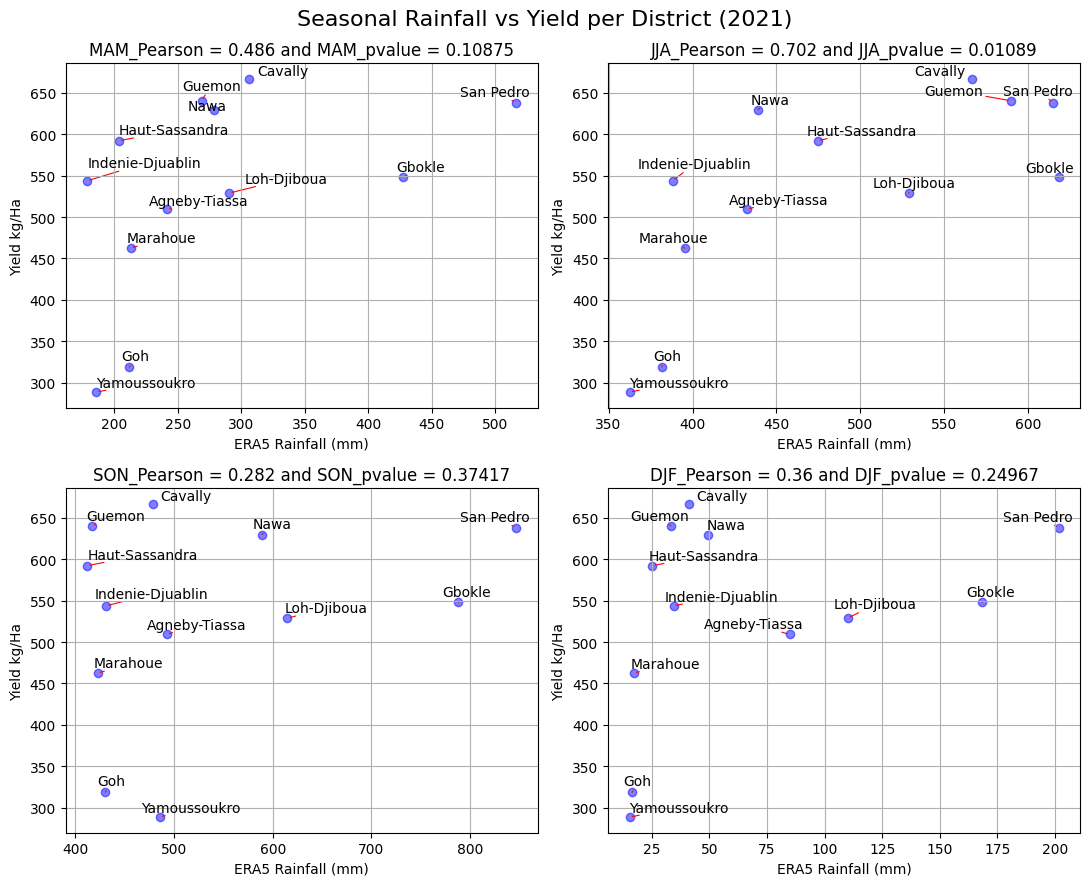

In [ ]:
L = ["MAM", "JJA", "SON", "DJF"]
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

for i, ax in enumerate(axes.flatten()):
    if i < 4:
        x_data = province_2021_with_ERA5[L[i] + "_rainfall_2021"]
        y_data = province_2021_with_ERA5['TotalVolume dry beans (kg)Per Ha']

        ax.scatter(x_data, y_data, color='blue', alpha=0.5)
        pearson_corr, pvalue = pearsonr(x_data, y_data)
        ax.set_title(L[i] + "_Pearson = " + str(round(pearson_corr, 3)) + " and " + L[i] + "_pvalue = " +
                     str(round(pvalue, 5)))
        ax.set_xlabel('ERA5 Rainfall (mm)')
        ax.set_ylabel('Yield kg/Ha')
        ax.grid(True)

        # Add text annotations
        texts = [ax.text(x, y, txt, ha='center', va='bottom') for x, y, txt in
                 zip(x_data, y_data, province_2021_with_ERA5['Province'])]

        # Adjust text positions to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8), ax=ax)

# Add a main title
fig.suptitle('Seasonal Rainfall vs Yield per District (2021)', fontsize=16)

plt.tight_layout()
plt.show()

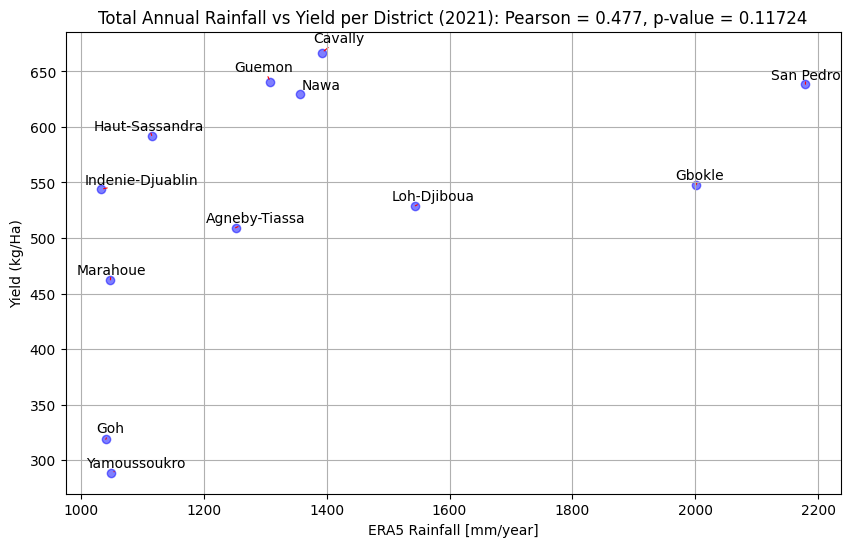

In [ ]:
pearson_corr, pvalue = pearsonr(province_2021_with_ERA5["RF_2021"], province_2021_with_ERA5["TotalVolume dry beans (kg)Per Ha"])

plt.figure(figsize=(10, 6))
plt.scatter(province_2021_with_ERA5["RF_2021"], province_2021_with_ERA5["TotalVolume dry beans (kg)Per Ha"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2021_with_ERA5["RF_2021"], province_2021_with_ERA5["TotalVolume dry beans (kg)Per Ha"], province_2021_with_ERA5["Province"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8))

plt.title('Total Annual Rainfall vs Yield per District (2021): Pearson = {:.3f}, p-value = {:.5f}'.format(pearson_corr, pvalue))

plt.xlabel('ERA5 Rainfall [mm/year]')
plt.ylabel('Yield (kg/Ha)')

plt.grid(True)
plt.show()

###Between Analysis Per District 2022


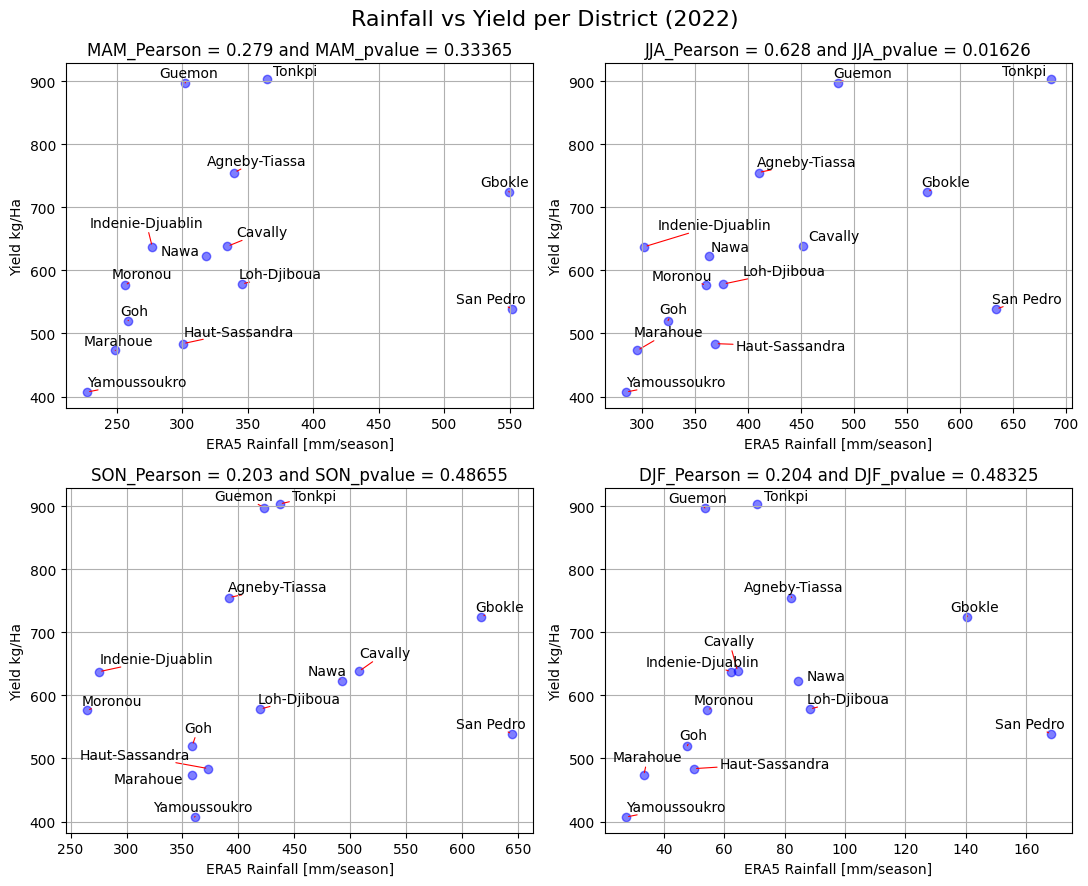

In [ ]:
L = ["MAM", "JJA", "SON", "DJF"]
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

for i, ax in enumerate(axes.flatten()):
    if i < 4:
        x_data = province_2022_with_ERA5[L[i] + "_rainfall_2022"]
        y_data = province_2022_with_ERA5['TotalVolume dry beans (kg)Per Ha']

        ax.scatter(x_data, y_data, color='blue', alpha=0.5)
        pearson_corr, pvalue = pearsonr(x_data, y_data)
        ax.set_title(L[i] + "_Pearson = " + str(round(pearson_corr, 3)) + " and " + L[i] + "_pvalue = " +
                     str(round(pvalue, 5)))
        ax.set_xlabel('ERA5 Rainfall [mm/season]')
        ax.set_ylabel('Yield kg/Ha')
        ax.grid(True)

        # Add text annotations
        texts = [ax.text(x, y, txt, ha='center', va='bottom') for x, y, txt in
                 zip(x_data, y_data, province_2022_with_ERA5['Province'])]

        # Adjust text positions to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8), ax=ax)

# Add a main title
fig.suptitle('Rainfall vs Yield per District (2022)', fontsize=16)

plt.tight_layout()
plt.show()

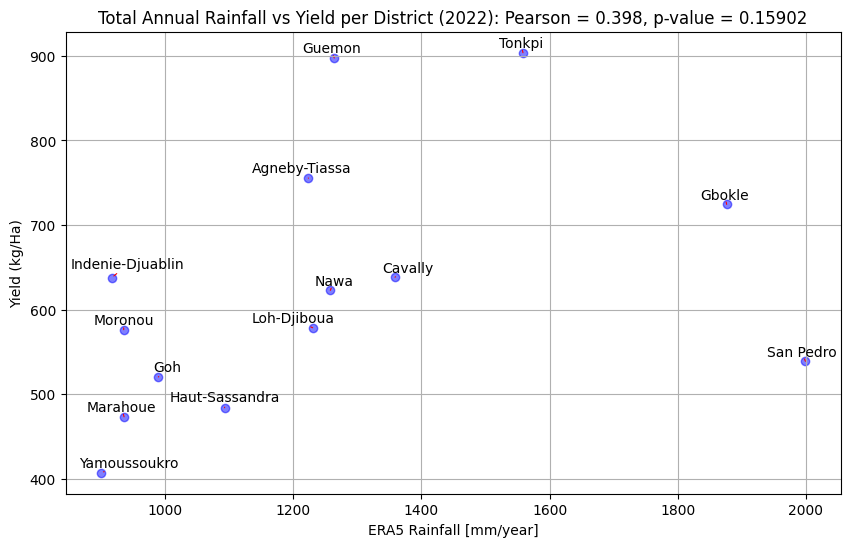

In [ ]:
pearson_corr, pvalue = pearsonr(province_2022_with_ERA5["RF_2022"], province_2022_with_ERA5["TotalVolume dry beans (kg)Per Ha"])

plt.figure(figsize=(10,6))
plt.scatter(province_2022_with_ERA5["RF_2022"], province_2022_with_ERA5["TotalVolume dry beans (kg)Per Ha"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2022_with_ERA5["RF_2022"], province_2022_with_ERA5["TotalVolume dry beans (kg)Per Ha"], province_2022_with_ERA5["Province"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8))

plt.title('Total Annual Rainfall vs Yield per District (2022): Pearson = {:.3f}, p-value = {:.5f}'.format(pearson_corr, pvalue))

plt.xlabel('ERA5 Rainfall [mm/year]')
plt.ylabel('Yield (kg/Ha)')

plt.grid(True)
plt.show()

###Within Analysis Per District

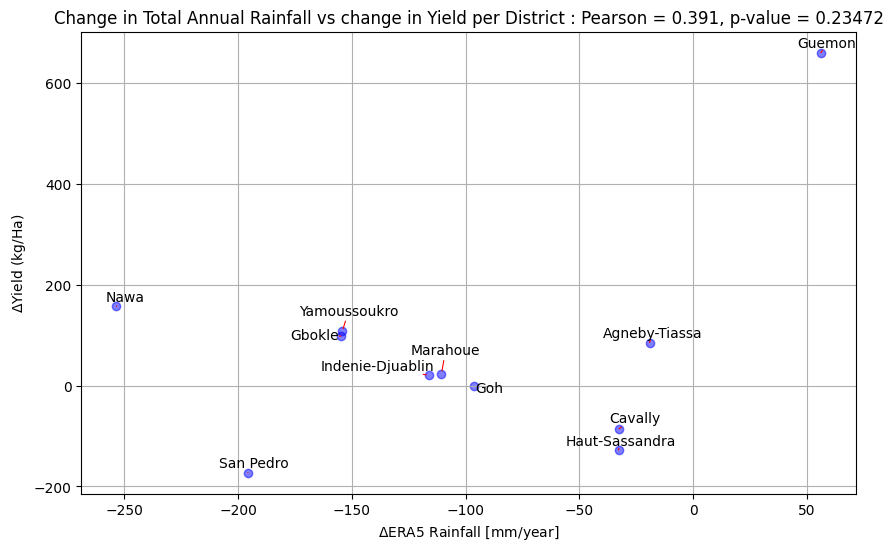

In [ ]:
#Calculate the average change in rainfall and yield based on district
province_2021_2022_ERA5 = merged_with_era5_2021_2022.groupby("Province_2021").agg({'yield_difference': 'mean', 'rainfall_difference': 'mean', 'rainfall_difference_MAM': 'mean', 'rainfall_difference_JJA':'mean', 'rainfall_difference_SON':'mean', 'rainfall_difference_DJF':'mean'}).reset_index()

pearson_corr, pvalue = pearsonr(province_2021_2022_ERA5["rainfall_difference"], province_2021_2022_ERA5["yield_difference"])

plt.figure(figsize=(10, 6))
plt.scatter(province_2021_2022_ERA5["rainfall_difference"], province_2021_2022_ERA5["yield_difference"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2021_2022_ERA5["rainfall_difference"], province_2021_2022_ERA5["yield_difference"], province_2021_2022_ERA5["Province_2021"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8))

plt.title('Change in Total Annual Rainfall vs change in Yield per District : Pearson = {:.3f}, p-value = {:.5f}'.format(pearson_corr, pvalue))

plt.xlabel('$\Delta$ERA5 Rainfall [mm/year]')
plt.ylabel('$\Delta$Yield (kg/Ha)')

plt.grid(True)
plt.show()

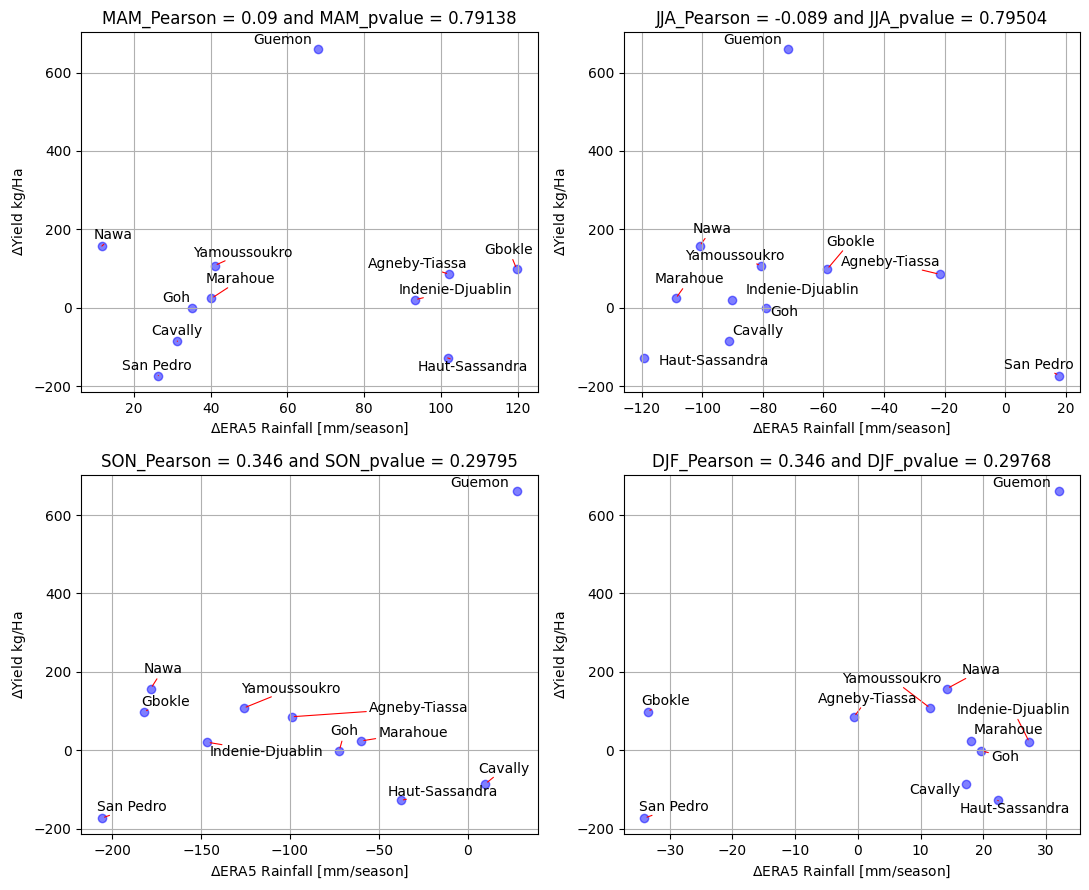

In [ ]:
L = ["MAM", "JJA", "SON", "DJF"]
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

for i, ax in enumerate(axes.flatten()):
    if i < 4:
        x_data = province_2021_2022_ERA5[r"rainfall_difference_" + L[i]]
        y_data = province_2021_2022_ERA5['yield_difference']

        ax.scatter(x_data, y_data, color='blue', alpha=0.5)
        pearson_corr, pvalue = pearsonr(x_data, y_data)
        ax.set_title(L[i] + "_Pearson = " + str(round(pearson_corr, 3)) + " and " + L[i] + "_pvalue = " +
                     str(round(pvalue, 5)))
        ax.set_xlabel('$\Delta$ERA5 Rainfall [mm/season]')
        ax.set_ylabel('$\Delta$Yield kg/Ha')
        ax.grid(True)

        # Add text annotations
        texts = [ax.text(x, y, txt, ha='center', va='bottom') for x, y, txt in
                 zip(x_data, y_data, province_2021_2022_ERA5['Province_2021'])]

        # Adjust text positions to avoid overlap
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8), ax=ax)

# # Add a main title
# fig.suptitle('Change in Seasonal Rainfall vs change in Yield per District (2021-2022)', fontsize=16)

plt.tight_layout()
plt.show()

##Finding the correlation between SprayingTotal cost and Yield

###Between Analysis(2021)

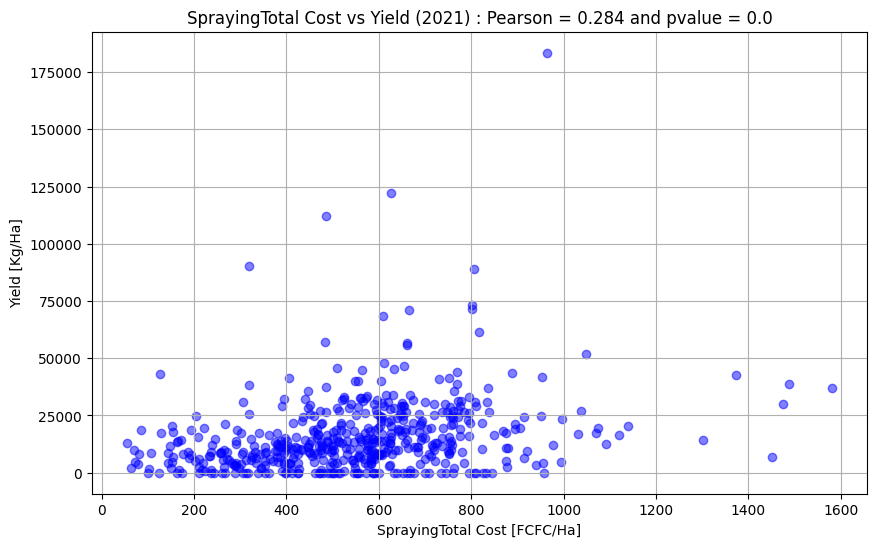

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_with_era5_2021["TotalVolume dry beans (kg)Per Ha"], merged_with_era5_2021["SprayingTotal cost (FCFA)Per Ha"], color='blue', alpha=0.5)

pearson_corr, pvalue = pearsonr(merged_with_era5_2021["TotalVolume dry beans (kg)Per Ha"], merged_with_era5_2021['SprayingTotal cost (FCFA)Per Ha'])

plt.title("SprayingTotal Cost vs Yield (2021) : Pearson = " + str(round(pearson_corr,3))+ " and pvalue = " +str(round(pvalue,4)))
plt.xlabel("SprayingTotal Cost [FCFC/Ha]")
plt.ylabel("Yield [Kg/Ha]")

plt.grid(True)
plt.show()

###Between Analysis(2022)

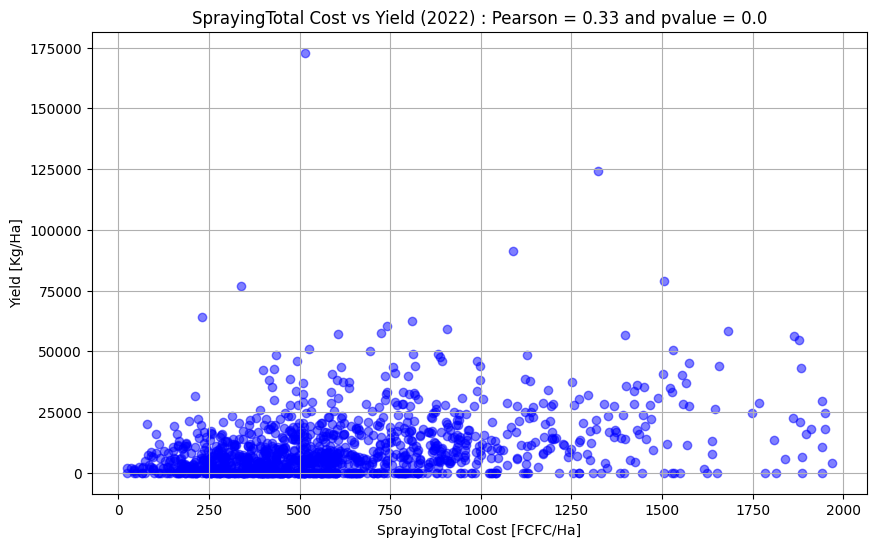

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_with_era5_2022["TotalVolume dry beans (kg)Per Ha"], merged_with_era5_2022["SprayingTotal cost (FCFA)Per Ha"], color='blue', alpha=0.5)

pearson_corr, pvalue = pearsonr(merged_with_era5_2022["TotalVolume dry beans (kg)Per Ha"], merged_with_era5_2022['SprayingTotal cost (FCFA)Per Ha'])

plt.title("SprayingTotal Cost vs Yield (2022) : Pearson = " + str(round(pearson_corr,3))+ " and pvalue = " +str(round(pvalue,4)))
plt.xlabel("SprayingTotal Cost [FCFC/Ha]")
plt.ylabel("Yield [Kg/Ha]")

plt.grid(True)
plt.show()

###Between Analysis Per District 2021

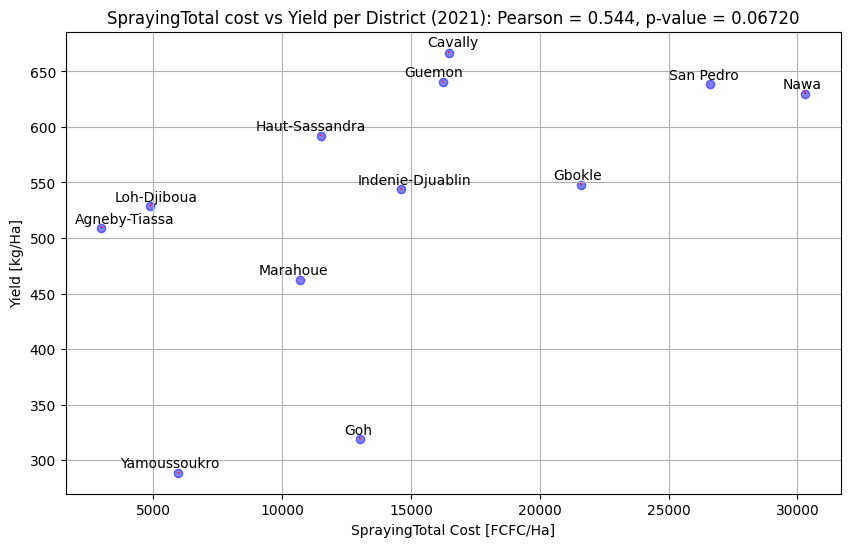

In [ ]:
pearson_corr, pvalue = pearsonr(province_2021_with_ERA5["SprayingTotal cost (FCFA)Per Ha"], province_2021_with_ERA5["TotalVolume dry beans (kg)Per Ha"])

plt.figure(figsize=(10, 6))
plt.scatter(province_2021_with_ERA5["SprayingTotal cost (FCFA)Per Ha"], province_2021_with_ERA5["TotalVolume dry beans (kg)Per Ha"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2021_with_ERA5["SprayingTotal cost (FCFA)Per Ha"], province_2021_with_ERA5["TotalVolume dry beans (kg)Per Ha"], province_2021_with_ERA5["Province"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8))

plt.title('SprayingTotal cost vs Yield per District (2021): Pearson = {:.3f}, p-value = {:.5f}'.format(pearson_corr, pvalue))

plt.xlabel('SprayingTotal Cost [FCFC/Ha]')
plt.ylabel('Yield [kg/Ha]')

plt.grid(True)
plt.show()

######Between Analysis Per District 2022

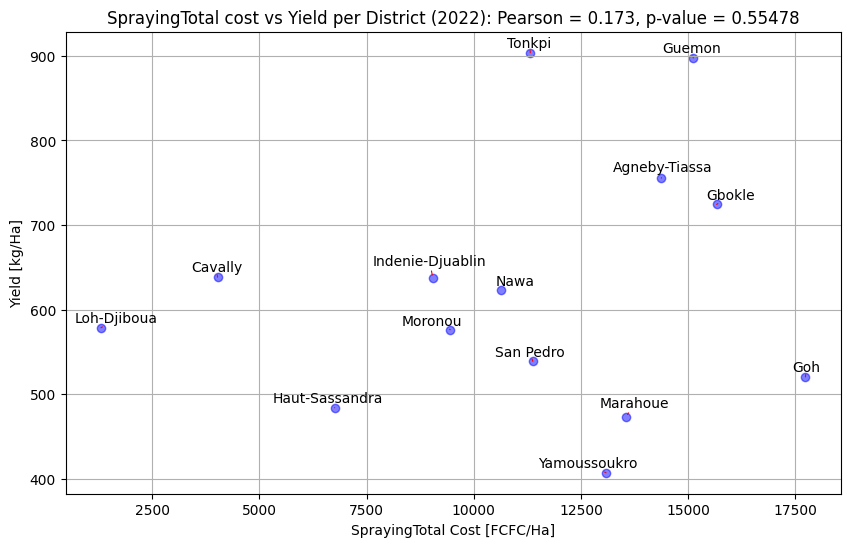

In [ ]:
pearson_corr, pvalue = pearsonr(province_2022_with_ERA5["SprayingTotal cost (FCFA)Per Ha"], province_2022_with_ERA5["TotalVolume dry beans (kg)Per Ha"])

plt.figure(figsize=(10, 6))
plt.scatter(province_2022_with_ERA5["SprayingTotal cost (FCFA)Per Ha"], province_2022_with_ERA5["TotalVolume dry beans (kg)Per Ha"], color='blue', alpha=0.5)

texts = []
for x, y, txt in zip(province_2022_with_ERA5["SprayingTotal cost (FCFA)Per Ha"], province_2022_with_ERA5["TotalVolume dry beans (kg)Per Ha"], province_2022_with_ERA5["Province"]):
    texts.append(plt.text(x, y, txt, ha='center', va='bottom'))

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='red', lw=0.8))

plt.title('SprayingTotal cost vs Yield per District (2022): Pearson = {:.3f}, p-value = {:.5f}'.format(pearson_corr, pvalue))

plt.xlabel('SprayingTotal Cost [FCFC/Ha]')
plt.ylabel('Yield [kg/Ha]')

plt.grid(True)
plt.show()